# Tittle: Identification of Marker Genes in Human Breast Tumors using scRNA 
# Introduction

Tamoxifen is a selective estrogen receptor modulator (SERM) medication used to treat breast cancer. breast cancer is a major type of cancer in females. Detecting cancer early poses a significant challenge due to its inherent heterogeneity. In ER-positive, HER2-negative breast cancer, multiple measures of intra-tumor heterogeneity are associated with worse response to endocrine therapy

Recent progress in next-generation technologies has facilitated the exploration of novel gene expressions involved in breast cancer pathogenesis. The utilization of Next-Generation Sequencing (NGS) methods has generated extensive datasets, necessitating computationally intensive analyses. Consequently, machine learning models have been deployed to effectively analyze these large datasets. Machine learning algorithms have demonstrated their effectiveness and computational efficiency in identifying disease biomarkers from high-dimensional datasets.

In this project, we leverage a single-cell-RNA dataset combined with machine learning techniques to identify and determine breast cancer biomarkers. To identify gene signatures associated with breast cancer for six different types of breast cancer tumors, we will use Scanpy.


# Research Questions
1. Which genes are differentially expressed in breat cancer?
2. Which genes are co-expressed in breast cancer?
3. What is the expression pattern of differentially expressed genes per cell type?
4. Which pathways are enriched in different cell types in breast cancer?

# Dataset

The dataset under consideration comprises samples from the population of live human tumors and normal breast specimens tha were taken immediately after surgical resection for processing into single-cell workflows for experimentation and genomic analyses.I this study, we show differences in tamoxifen response by cell type. The data set was obtained from NCBI GEO database under the accession number GSE245601

# Methodology
- Data Acqusition: h5 format
- Preprocessing and Quality control: Gene, cell and mitochondria filtering
- Clustering: UMAP
- Data Visualization: Dot plots,violin, track plots,scatter plots, heatmaps
- Benchmarking: Literature Search

In [154]:
# ignore warnings and standasrd outputs
# Filtering warnings from current version of matplotlib
import warnings

warnings.filterwarnings(
    "ignore", message=".*Parameters 'cmap' will be ignored.*", category=UserWarning
)
warnings.filterwarnings(
    "ignore", message="Tight layout not applied.*", category=UserWarning
)

# Workflow

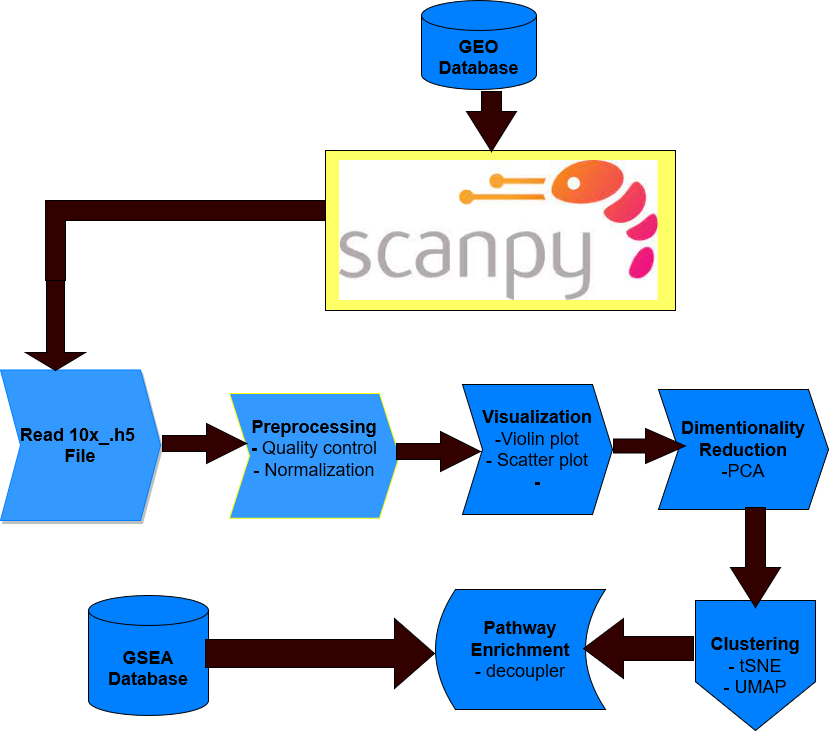

In [258]:
from IPython.display import Image, display

# Replace 'path_to_your_image.jpg' with the actual path to your image file
image_path = 'scanpy_workflow.png'

# Display the image
display(Image(filename=image_path))


# Data Acquisition
The datset was downloaded using ftp commandline as follows
Counts data

!wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE118nnn/GSE118389/suppl/GSE118389%5Fnorm%5Fdata%2Etxt%2Egz

The counts data represent the number of RNA sequencing reads that have been aligned to each gene in the transcriptome. These counts can be indicative of the level of gene expression in the samples. The file contains gene expression data in the form of counts, derived from RNA sequencing experiments

Normalized counts data
! wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE118nnn/GSE118389/suppl/GSE118389%5Fnorm%5Fdata%2Etxt%2Egz

This file likely contains normalized gene expression data from the same RNA sequencing experiments.
Normalization is a process used to adjust for technical variations between samples, allowing for more accurate comparisons of gene expression levels across different experimental conditions or samples.


# Scanpy set up and loading required libraries

In [217]:
import pandas as pd
import scanpy as sc
import os
import numpy as np
import scipy
import scipy.io as sio
import pandas as pd
import warnings
import decoupler
import seaborn.objects as so
warnings.simplefilter(action='ignore', category=FutureWarning)# supress some warnings
sc.settings.verbosity = 3

# Data integration
The data was in multiple .h5 files. We used a function to merge the different files into a single file

In [95]:
import h5py
import os
output_file = "output.h5"
folder_path = "../data/"

output_file = "../data/output.h5"

# Get a list of H5 files in the folder
d_names = [f for f in os.listdir(folder_path) if f.endswith('Control.h5')]

# Dictionary to store the database structure
d_struct = {}

# Iterate over H5 files and get group names
for i in d_names:
    path = os.path.join(folder_path, i)
    # print(path)

    with h5py.File(path, 'r') as f:
        d_struct[i] = list(f.keys())

# Create the output H5 file
with h5py.File(output_file, 'w') as outfile:
    # Iterate over H5 files and copy datasets to the output file
    for i in d_names:
        path = os.path.join(folder_path, i)
        with h5py.File(path, 'r') as f:
            for j in d_struct[i]:
                # Check if the dataset already exists in the output file
                if j in outfile:
                    continue
                    # print(f"Dataset '{j}' already exists in the output file. Skipping.")
                else:
                    # Copy dataset from the original file to the output file
                    f.copy(j, outfile, name=j)

# print("Datasets copied successfully.")

In [96]:
#Load data
data= sc.read_10x_h5("../data/output.h5")

reading ../data/output.h5
 (0:00:01)


# Data Wrangling/ Exploratory Data Analysis
In this section, we will answer below questions
- How many genes are in the raw count dataset?
- How many cells?
- Are there mitochondria contaminants?
- Which genes are highly expressed?


Number of cells (observations or n_obs): 4267

Number of genes (variables or n_vars): 33538

In [97]:
# data
#check total number of mitochondrial genes in the dataset
data.var_names.str.contains("MT-").sum()

14

In [98]:
 # annotate the group of mitochondrial genes as 'MT'
data.var['MT'] = data.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(data, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

In [99]:
# check the genes and count statistics 
data.var

,gene_ids,feature_types,genome,MT,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0
FAM138A,ENSG00000237613,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0
OR4F5,ENSG00000186092,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,14,0.003281,99.671901,14.0
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,False,2,0.000469,99.953129,2.0
...,...,...,...,...,...,...,...,...
AC233755.2,ENSG00000277856,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0
AC233755.1,ENSG00000275063,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0
AC240274.1,ENSG00000271254,Gene Expression,GRCh38,False,228,0.067260,94.656667,287.0
AC213203.1,ENSG00000277475,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0


In [100]:
#make the gene names unique
data.var_names_make_unique()

# Quality Control and Filtering
- Mitochondrial gene composition.
Mitochondrial genes often start with "MT-" or "MTRNR," and their inclusion helps estimate the mitochondrial composition of each cell. Most of the cells have a mitochondria count percentage below 15%. The cells with higher than 15% mitochondria count may signify cell stress and damage and were therefore filterd out.
- Cell counts. Cells with less than 500 genes were excluded from downstream analysis. The low gene count in cells can be due to low capture, inefficient cell lysis or non-viable cells.
Each violin plot represents the distribution of the number of genes expressed per cell.
- Gene counts
- Cells with less than 20000 total count were excluded from the analysis.


## Violin Plot

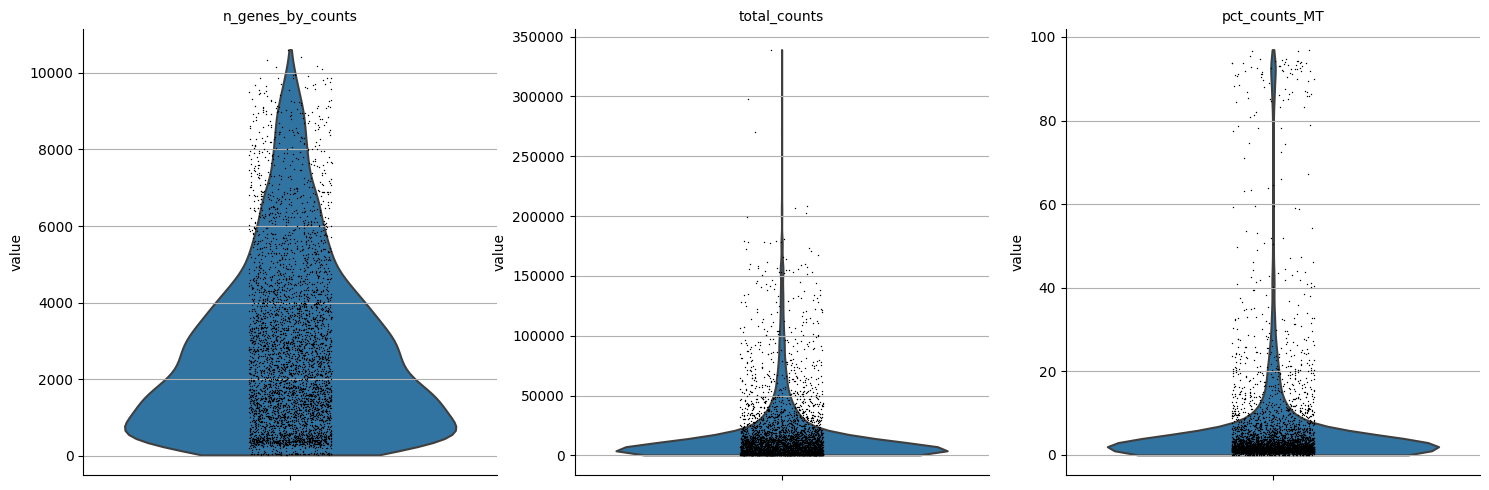

In [101]:
sc.pl.violin(
    data, 
    [
     'n_genes_by_counts', 
     'total_counts', 
     'pct_counts_MT'
     ],
    multi_panel=True,
    # save='_gene_MT_vs_transcript_counts',
);

## Scatter Plots

The plots indicate that some reads have a relatively high percentage of mitochondrial counts which are often associated with cell degradation. However, most of the cells have less than 15% mitochondria percentage which. We can also observe most cells have total counts of below 20000. For gene counts per cell, most cells approximately contain about 5000 gene counts on average. These visualizations were used to set the quality control thresholds. We also filter out genes that are not detected in at least 20 cells as these are not informative.

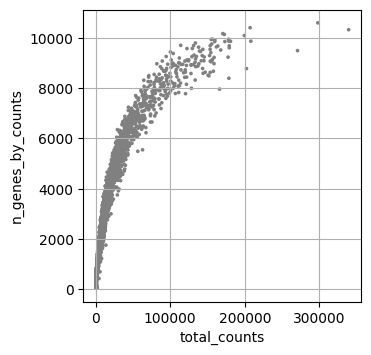

In [102]:
sc.pl.scatter(data, "total_counts", "n_genes_by_counts")

The scatter plot shows gene counts per each gene. The output shows presence of potential outliers for gene counts

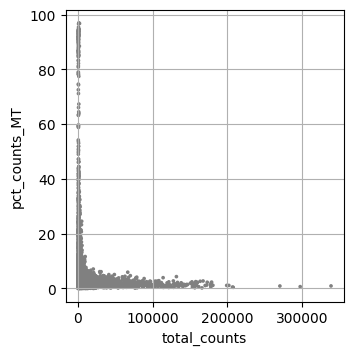

In [103]:
sc.pl.scatter(data, "total_counts", "pct_counts_MT")

From the scatter plot, few cells have mitochondria composition above 15% which is the desirable threshold. We will filter cells with a percentage count above 15% mitochondria count

In [104]:
# Filter the data
data = data[data.obs.n_genes_by_counts < 5000,:]
data = data[data.obs.total_counts < 20000,:]
data = data[data.obs.pct_counts_MT < 15,:]
# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(data, min_cells=20)
data.shape # Checking number of cells remaining

filtered out 19290 genes that are detected in less than 20 cells


(2972, 14248)

We have filtered cells with less than 500 genes, cells with less than 20000 total count and cells with more than 15% mitochondrial gene composition and genes that are only present in 20 cells or less.

## Violin plots after QC

After filtering, the number of genes remaining is 2972 and the number of cells remainaing is 33538

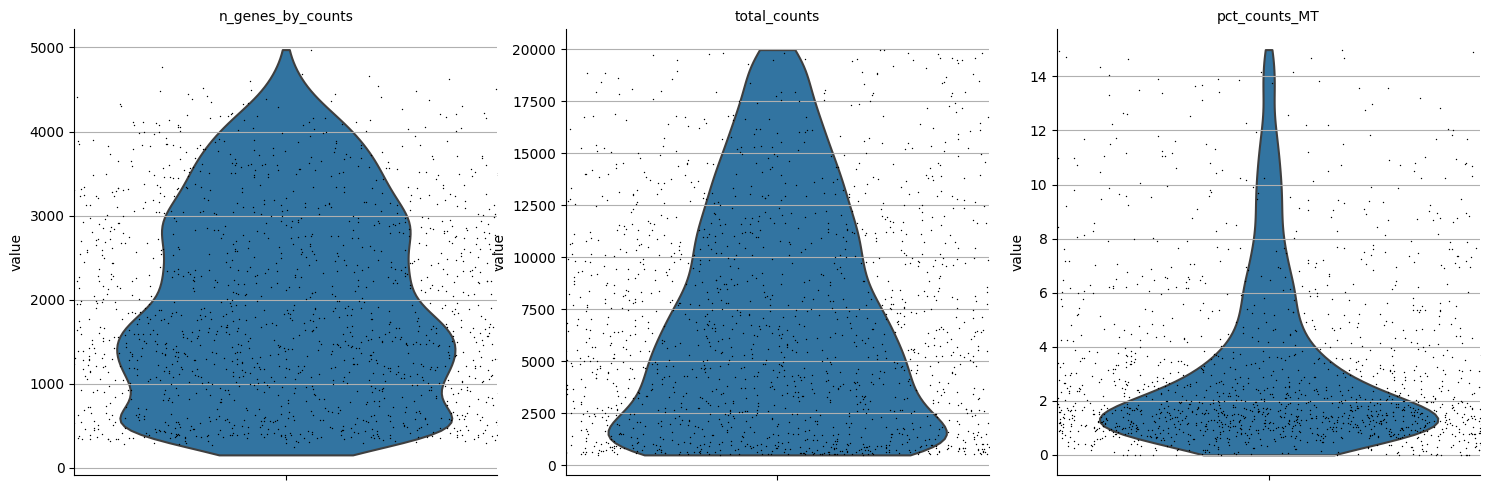

In [105]:
sc.pl.violin(
    data, 
    [
     'n_genes_by_counts', 
     'total_counts', 
     'pct_counts_MT'
     ],
    jitter=1,
    multi_panel=True,
    # save='Filtered_gene_MT_vs_transcript_counts'
   
)


After the quality control, we can see the interquartile ranges for gene counts, total counts and mitochondria composition are within the expected ranges based on the previous filtered parameters. 

## Scatter plot after QC

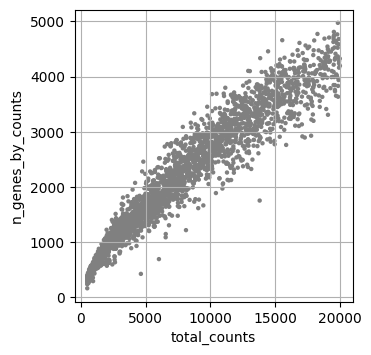

In [106]:
sc.pl.scatter(data, x='total_counts', y='n_genes_by_counts')

The scatter plot shows the distribution of the number of gene counts. We can see the gene counts increase with the increase in total counts for the genes. The plot also shows the presence of potential outliers in some gene counts. Before filtering, we can normalize the counts and visualize nwe the distribution.

# Normalization
This step is performed to account for technical biases and variability across cells, ensuring that the observed differences in gene expression are reflective of biological signals rather than technical artifacts. For example
- Each cell in a scRNA-seq experiment may have a different number of RNA molecules, resulting in variability in library sizes
-  samples are processed at different times, and batch effects can introduce unwanted variability.
-   Longer genes generally produce more sequencing reads, and some cells may be sequenced more deeply than others.
-   Technical variations such as amplification bias, and sequencing biases
  
In this project, transcripts per million (TPm) normalization and log normalization have been used. The log normalization was adopted since scRNA has high variance.

In [107]:
#normarization
data.layers["counts"] = data.X.copy() # preserve counts
sc.pp.normalize_total(data, target_sum=1e6) # scale each cell to a common library size
sc.pp.log1p(data) # log(expression + 1)
data.raw = data # freeze the state in `.raw`

normalizing counts per cell
    finished (0:00:00)


## Gene counts after QC and Normalization

In [108]:
print("min_gene count is ", data.obs["n_genes_by_counts"].min(), "\n max_gene count is ",data.obs["n_genes_by_counts"].max())

min_gene count is  155 
 max_gene count is  4974


In [109]:
data.obs["n_genes_by_counts"].max()

4974

# Highly variable genes
Discarding non-significant genes that are equally expressed across the cells is a preprocessing step in scRNA-seq analysis. This process is performed to reduce noise, to focus on the most informative genes, and improve the efficiency of downstream analyses. After extracting highly variable genes, we see that only 6684 genes remained for downstream analysis.

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


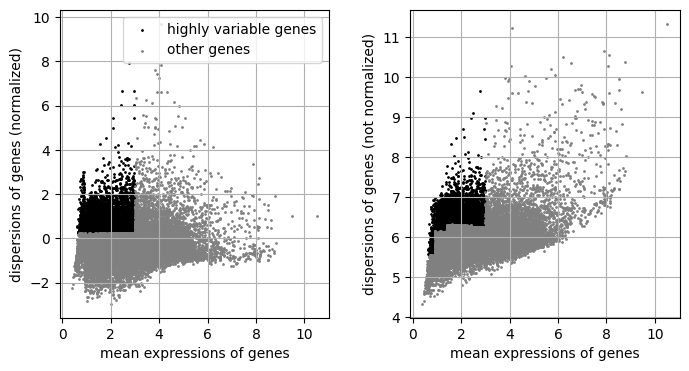

In [110]:
#determining High variable genes
sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.25)
sc.pl.highly_variable_genes(data) 

The plots show that before normalization, the dispersion of genes have wide range from 3.2 to 3.9. Aftwr bnormalization, there is positive and negative dispersion ranging from -2 to 2. Genes with a mean expression below 0.25 dispersion  threshold were excluded from consideration as highly variable genes

In [111]:
data.raw=data
data = data[:, data.var['highly_variable']]
sc.pp.scale(data, zero_center=True, max_value=3)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [112]:
print("min_nom",data.var["dispersions_norm"].min(),"\nmax_norm is",data.var["dispersions_norm"].max())

min_nom 0.25018993 
max_norm is 7.9066873


normalizing counts per cell
    finished (0:00:00)


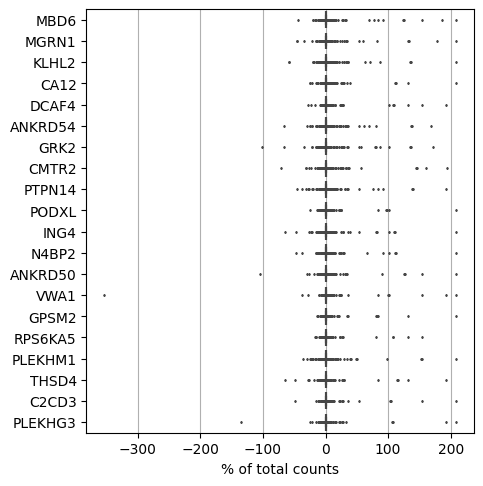

In [113]:
sc.pl.highest_expr_genes(data, n_top=20)

From the plot, the gene which is most  variable is MBD6

In [114]:
top_1500Genes=sc.pp.highly_variable_genes(data, flavor="seurat", n_top_genes=1500)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


# Dimentionality reduction (PCA)

From the plot, among highest variable gene is ABCC9

In [115]:
# # Perform PCA
# sc.tl.pca(data)
# # Visualize PCA results
# sc.pl.pca(data, color='leiden')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)


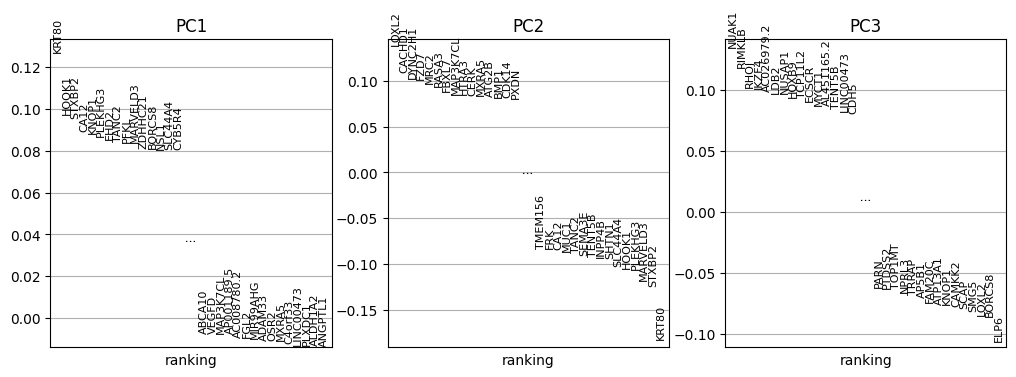

In [116]:
# Perform PCA
sc.tl.pca(data)
# Visualize PCA loadings
sc.pl.pca_loadings(data, show=True)  #

From the PCA results, we can see that gene KRT80 is the most differentially expressed in the cells for PC1. Other genes such as ABCA10 contribute to almost no variation in the expression patterns for PCA1. In PC2, the LOXL2 gene contributes most to the observed gene expression patterns in the cells. Some genes such as STXBP2 seem to be very lowly expressed in some cells and it contributes to the variation in gene expression patterns for PC2. For PC3, the gene NUAK1 is upregualted in some cells causing the variation in the expression patterns whereas gene ELP6 seems to be underexpressed among the cell types. These genes can therefore be potential biomarkers for breast cancer disease. The number of PCA to use varies with the sample and optimal PCA should be determined for optimal variation in the samples. We can extract the contribution of each PCA and accumulated variance and pick the optimal at the elbow position of th plot as shown in the next figure. The optimal PCAs are  9. 

Perone, Y., Farrugia, A. J., Rodríguez-Meira, A., Győrffy, B., Ion, C., Uggetti, A., ... & Magnani, L. (2019). SREBP1 drives Keratin-80-dependent cytoskeletal changes and invasive behavior in endocrine-resistant ERα breast cancer. Nature communications, 10(1), 2115.  (KRT80)

Mamoor, S. (2023). ABCA10 is a differentially expressed gene in brain metastatic human breast cancer. (ABCA10)

Ahn, S. G., Dong, S. M., Oshima, A., Kim, W. H., Lee, H. M., Lee, S. A., ... & Green, J. E. (2013). LOXL2 expression is associated with invasiveness and negatively influences survival in breast cancer patients. Breast cancer research and treatment, 141, 89-99. (LOXL2)


Kuehn, J., Espinoza‐Sanchez, N. A., Teixeira, F. C., Pavão, M. S., Kiesel, L., Győrffy, B., ... & Götte, M. (2021). Prognostic significance of hedgehog signaling network‐related gene expression in breast cancer patients. Journal of Cellular Biochemistry, 122(5), 577-597. (ELP6)


Orlandella, F. M., Mariniello, R. M., Mirabelli, P., De Stefano, A. E., Iervolino, P. L. C., Lasorsa, V. A., ... & Salvatore, G. (2020). miR-622 is a novel potential biomarker of breast carcinoma and impairs motility of breast cancer cells through targeting NUAK1 kinase. British journal of cancer, 123(3), 426-437. (NUAK1)

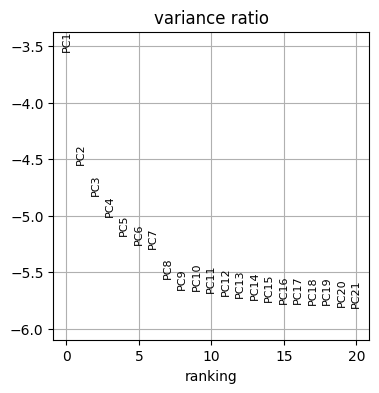

In [117]:
# Visualize PCA variance ratio
sc.pl.pca_variance_ratio(data, n_pcs=20, log=True, show=True)

# Clustering
We will use UMAP and tSNE clustering and 8 PCAs already determined

We will pick number of components to be 8 as this is the optimal PCS from the output of the PCs tested. Only PC1 has positive positive loadings indicating higher expression levels of those genes contribute to higher values of that PC. The remaininng PCs suggest that lower expression levels of those genes contribute to higher values of that PC.

In [118]:
sc.pp.neighbors(data,n_pcs=8)
sc.tl.umap(data)
sc.tl.leiden(data, key_added="clusters")

computing neighbors
    using 'X_pca' with n_pcs = 8
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)
running Leiden clustering
    finished: found 13 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:02)


In [119]:
sc.tl.leiden(data)

running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


# Embedding
The leiden algorithm groups cells based on the closeness of their expression patterns. We will use tSNA,and UMAP

computing tSNE
    using 'X_pca' with n_pcs = 8
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:32)


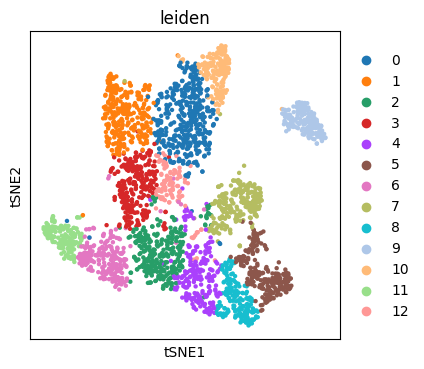

In [120]:
# Embeddings'
# Perform t-SNE
sc.tl.tsne(data,n_pcs=8)
## tSNE
sc.pl.tsne(data, color='leiden')

We can see 19 distinct clusets for the cell types after tSNE. t-SNE is a nonlinear dimensionality reduction technique commonly used for visualizing high-dimensional data in two or three dimensions. It emphasizes the preservation of local structures, making it well-suited for revealing clusters or groups of cells with similar gene expression profiles.

In [121]:
# # Compute a custom embedding (e.g., UMAP)
# sc.tl.umap(data,n_components=9)
# # Visualize cells in the UMAP space
# sc.pl.embedding(data, basis='umap', color='leiden')

In [122]:
# import numpy as np
# import seaborn as sns
# np.random.seed(42)
# data.obs['condition'] = np.random.choice(['healthy', 'tumor'], size=len(data))

# # Compute UMAP embedding
# sc.tl.umap(data)

# # Visualize the density of cells in the UMAP embedding per condition
# sc.pl.embedding_density(data, basis='umap', key='condition', cmap=sns.color_palette("Set2", as_cmap=True))

# plt.show()

In [123]:
data.obs

,n_genes_by_counts,total_counts,total_counts_MT,pct_counts_MT,clusters,leiden
AAACCCAAGTCAGGGT-1,1036,3271.0,227.0,6.939774,3,3
AAACCCACATCACAGT-1,1720,6521.0,70.0,1.073455,0,0
AAACCCATCTCAATCT-1,1190,3436.0,299.0,8.701980,6,6
AAACGAACAAGTTCGT-1,2464,7967.0,91.0,1.142212,7,7
AAACGAATCTACCCAC-1,2851,9582.0,67.0,0.699228,0,0
...,...,...,...,...,...,...
TTTGGTTGTAGTTCCA-1,2728,6481.0,93.0,1.434964,7,7
TTTGTTGCAGGCCTGT-1,2973,9842.0,354.0,3.596830,5,5
TTTGTTGGTAATGATG-1,1143,3268.0,16.0,0.489596,3,3
TTTGTTGTCCTACAAG-1,4111,14885.0,212.0,1.424253,10,10


## Clustering of  cell types
Leiden algorithm was be used for hierarchical clustering, allowing for to discover and characterize cell types or states within a heterogeneous sample. We will compare tSNE and UMAP clustering to see which one provides more reasonale clusteers. In each case we will use PCAs of 9.

## UMAP clustering
UMAP was used as an effective preprocessing step to boost the performance of density based clustering.

In [125]:
sc.pp.neighbors(data,n_pcs=8)
sc.tl.umap(data,n_components=8)
sc.tl.leiden(data, key_added="clusters")

computing neighbors
    using 'X_pca' with n_pcs = 8
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)
running Leiden clustering
    finished: found 13 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:02)


In [126]:
sc.tl.leiden(data)

running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


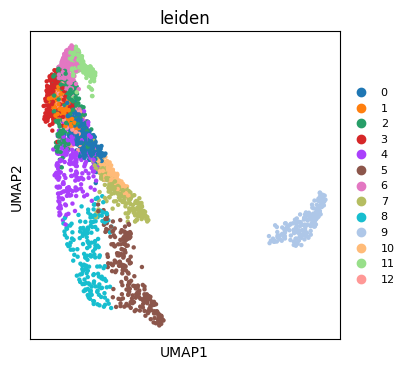

In [127]:
sc.pl.umap(data, color=['leiden'], legend_fontsize=8)

# Ranking genes per cell type

In [ ]:
# Extracting top 1500 genes
top_1500Genes=sc.pp.highly_variable_genes(data, flavor="seurat", n_top_genes=1500)
top_1500Genes

We can again see 19 clusters from UMAP clustering. However, the tSNE seems to be giving cleaer distictness among the clusters. In the next steps, we are going to unpack each category to determine which genes are differentially expressed in the cell categories.

In [128]:
import scanpy as sc
import pandas as pd
from matplotlib import rcParams
sc.tl.rank_genes_groups(data, 'leiden', method='t-test')
# The head function returns the top n genes per cluster
top_markers = pd.DataFrame(data.uns['rank_genes_groups']['names']).head(5)
# print(top_markers)
top_markers

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,CTSL,GEM,PLCG2,DCN,AREG,SPINT2,PLCG2,KRT7,KRT18,HLA-C,GSTO1,IGFBP7,RPS27
1,GSTO1,GADD45B,KRT14,GEM,KRT19,KRT18,SELE,TPM1,AREG,HLA-B,PRRX1,IFI27,PRRX1
2,TNFAIP6,NR4A1,MALAT1,MEG3,KRT18,CLDN7,MALAT1,GAPDH,KRT8,CYBA,PKM,B2M,TNFAIP6
3,PRRX1,PNRC1,SAA1,GADD45B,AZGP1,EPCAM,C2CD4B,KRT17,C15orf48,B2M,CTSL,HLA-E,CTSL
4,MEDAG,LGALS1,HIST1H3A,APOD,WFDC2,ANXA3,GNG11,PDCD5,ELF3,CXCR4,MEDAG,TM4SF1,IL1R1


# Top Marker genes by cluster
The top gene per category of cells have been extracted for spatial analysis i.e to get the patterns of tgeir distribution in other cells. From the results of the marker gene extraction after log nomalization and quakity control, CTSL gene is the most variable gene across the cell types.

## steps
- Obtain highly variable genes
- Rank the genes in order of counts
- Cluster the genes into distinct groups
- Rank the genes in each cluster


In [129]:
top_genes_list = []

# Iterate over the columns (categories) of the DataFrame
for col in top_markers.columns:
    # Extract the top genes for the current category and convert them to a list
    top_genes_sublist = top_markers[col].tolist()[0]
    
    # Append the sublist of top genes to the main list
    top_genes_list.append(top_genes_sublist)
top_genes_list.insert(13,"KRT8") # check confirmation from literature of co-experession between KRT8 and KRT18
# Print the list of lists
top_genes_list

['CTSL',
 'GEM',
 'PLCG2',
 'DCN',
 'AREG',
 'SPINT2',
 'PLCG2',
 'KRT7',
 'KRT18',
 'HLA-C',
 'GSTO1',
 'IGFBP7',
 'RPS27',
 'KRT8']

In [130]:
marker_genes = list(set(top_genes_list))

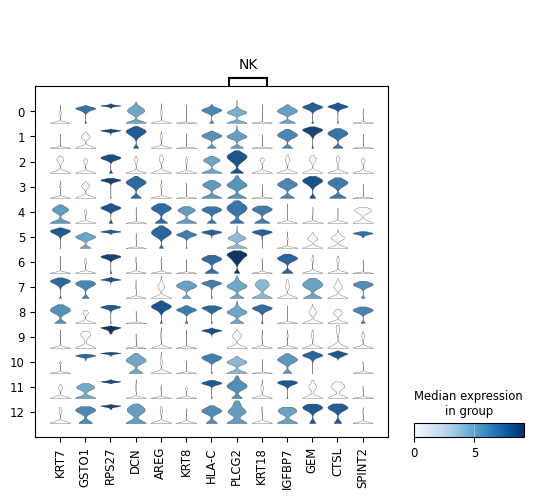

In [131]:
# Marker genes per cluster
ax = sc.pl.stacked_violin(data, marker_genes, groupby='leiden',
                         var_group_positions=[(7, 8)], var_group_labels=['NK'])

Genes such as CTSL are expressed in more than one type of cells in clusters 12, 10, 1 and 0. We can visualize the gene clustering using a dot plot with a dendrogram
to show the relatedness and level of the gene expression across different cells as shown below. Track plot also shows the gene expression profiles using baar graphs as shown below.

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


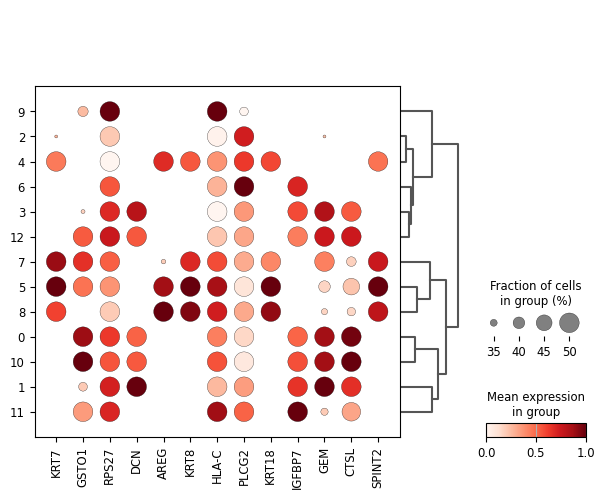

In [132]:
ax = sc.pl.dotplot(data, marker_genes, groupby='leiden', dendrogram=True, dot_max=0.5, dot_min=0.3, standard_scale='var')

From the dot plot and using the top selected genes per cluster, expression patterns in clusters 8 and 9 are closer than other expression patterns. Also, classes 2 and 10 are closely related in their expression patterns.  Among the cell types, CTSL is the highest expressed in all the six cell types. AREG gene is highly expressed in two cell types for clusters 9 and 5. The output also suggests co-expression patterns for KRT8 and KRT18. This is evident by the fact that clusters that show differential expression for the AREG gene also have differential expression of the KRT18 gene. Some genes are also shown to be interrelated and may be involved in similar metabolic pathways. For example. In cluster 11, CTSL, SRGN, and HLA-DQA1 are highly expressed and their overexpressed seems to cause the underexpression of AREG, TNFA1P6, and CXCR4. 



# Cell types based on marker genes

We can use the marker gene to identify the cell types. These marker genes were obtained from the literature.

categories: 0, 1, 2, etc.
var_group_labels: B-cell, T-cell, T-cell CD8+, etc.


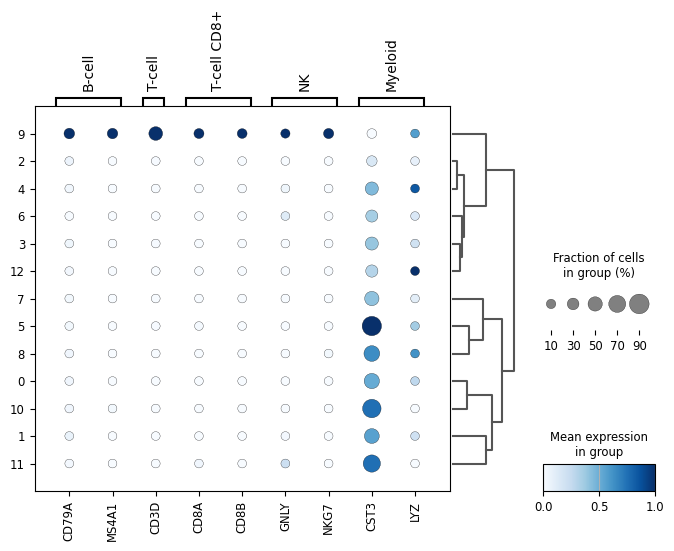

In [133]:

marker_genes_dict = {'B-cell': ['CD79A', 'MS4A1'],
                     'T-cell': 'CD3D',
                     'T-cell CD8+': ['CD8A', 'CD8B'],
                     'NK': ['GNLY', 'NKG7'],
                     'Myeloid': ['CST3', 'LYZ'],
                     # 'Monocytes': ['FCGR3A'],
                     # 'Dendritic': ['FCER1A']
                    }


ax = sc.pl.dotplot(data, marker_genes_dict, groupby='leiden', dendrogram=True,
                   standard_scale='var', smallest_dot=40, color_map='Blues', figsize=(8,5))

# Track plots
Track plots is another way of visualizing expression patterns of genes per cell type

In [134]:
# Track plot data is better visualized using the non-log counts
import numpy as np
ad = data.copy()
ad.raw.X.data = np.exp(ad.raw.X.data)

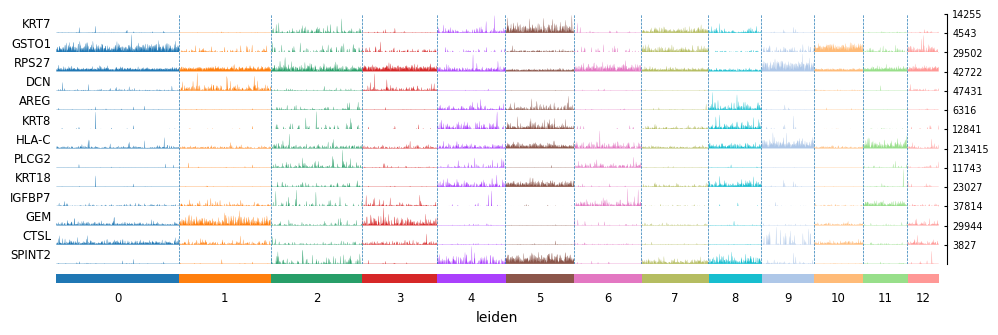

In [135]:
ax = sc.pl.tracksplot(ad,marker_genes, groupby='leiden')

 We can see similar expression patterns in clusster 6  and 7 . These clusters show similar density pattens

# Marker gene Visualization

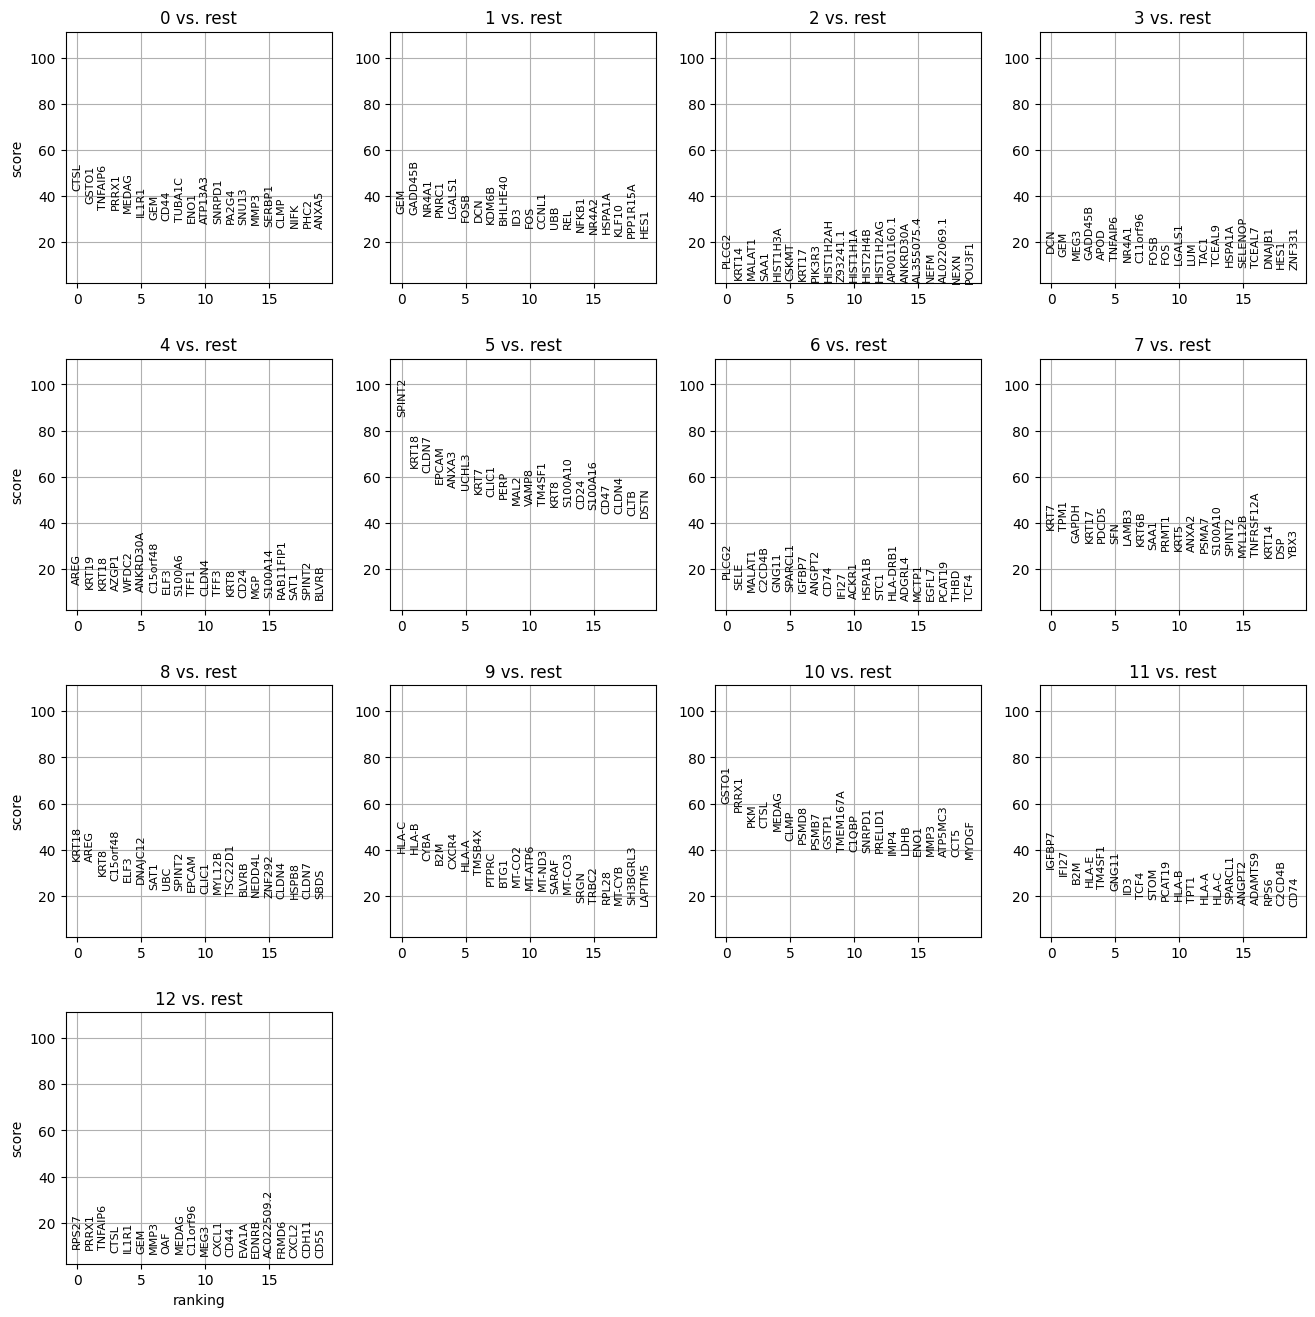

In [136]:
#v one vs rest visualization
rcParams['figure.figsize'] = 4,4
rcParams['axes.grid'] = True
sc.pl.rank_genes_groups(data)

Among the top cell-specific expressed genes are 'CTSL', 'GEM', 'PLCG2', 'DCN', 'AREG', 'SPINT2', 'PLCG2', 'KRT7', 'KRT18', 'HLA-C', 'GSTO1', 'IGFBP7', 'RPS27',
'KRT8'

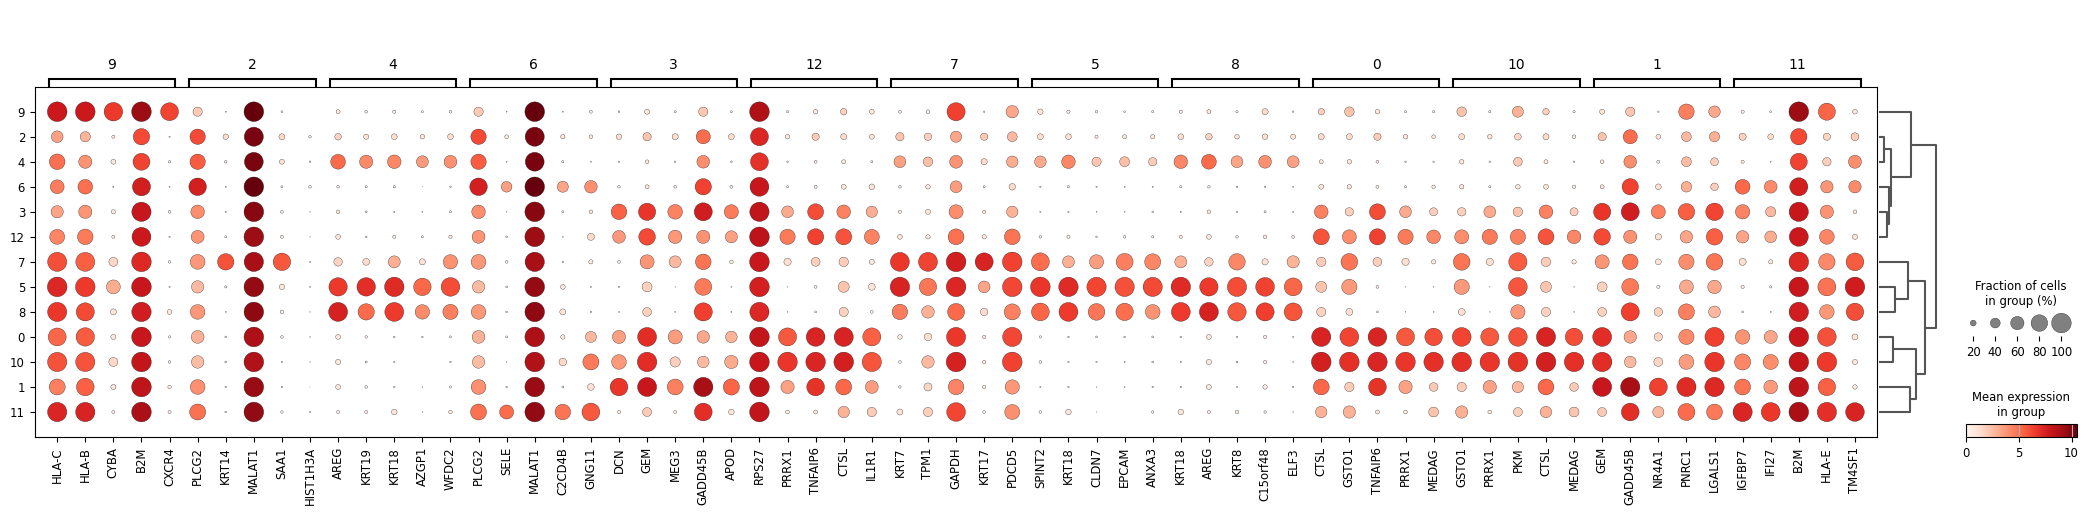

In [137]:
sc.pl.rank_genes_groups_dotplot(data, n_genes=5)

Plot showing top 4 gene expression patterns per cell category. For example, cluser 6 and 2 show similar expression patterns for gene MALAT 1 Cluster 7 and Cluster 6 show closely related expression patterns for the differentially expressed genes. There is evidence for co-expression patterns in genes such as IGFBP7 and FI27 in cluster 11. The MALAT1 gene has overexpression patterns in cell types 2 and 6

# Heat Map for differentially exprssed genes per  cell type category

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_clusters']`
categories: 0, 1, 2, etc.
var_group_labels: 5


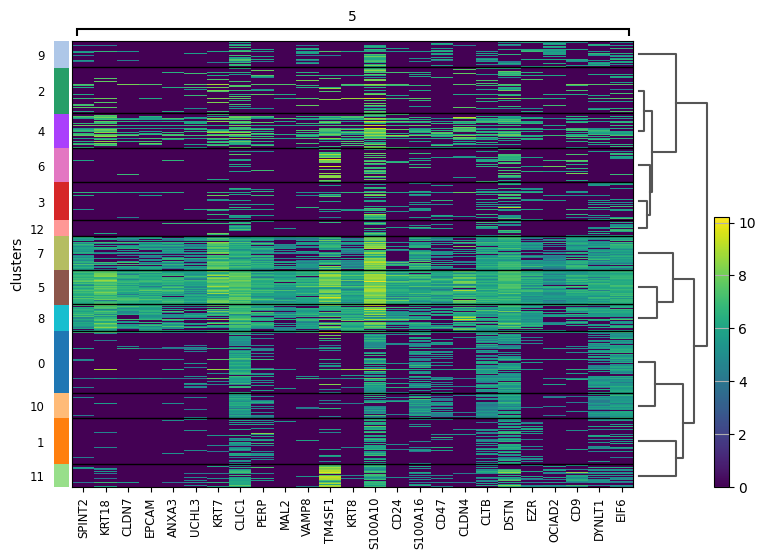

In [138]:
sc.tl.rank_genes_groups(data, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(data, groups="5", n_genes=25, groupby="clusters")

S1006A stands out as the most overexpressed gene in most of the cell types. Clusers 4 and 11 show the highest differentially expressed genes

# Pathway Analysis


Let’s extract the ranks for genes differentially expressed in cluster 0. We use these ranks and the gene sets from REACTOME to find gene sets enriched in this cell population compared to all other populations using GSEA as implemented in decoupler.

In [156]:
data

AnnData object with n_obs × n_vars = 2972 × 3259
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'clusters', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'tsne', 'leiden_colors', 'rank_genes_groups', 'dendrogram_leiden', 'clusters_colors', 'dendrogram_clusters'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

We will define a function to get differentially expressed genes in each cell type vs the rest. We will then call the function and pass in the cluster of the cell category to obtain the sorted ranks of genes in order of differential expression 

In [198]:
#Lets use top 1500 genes
sc.tl.rank_genes_groups(data, 'leiden',n_top_genes=1500, method='t-test')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [213]:
def get_scores(cluster):
    # Perform differential expression testing with the desired method ('t-test')
    scores = pd.DataFrame(data.uns['rank_genes_groups']['scores'])[cluster]
    gene_names = pd.DataFrame(data.uns['rank_genes_groups']['names'])[cluster]
    # Create a DataFrame with gene names in the first column and scores in the second column
    top_markers = pd.DataFrame({'Gene Names': gene_names, 'Scores': scores})
    
    # sort the DataFrame by absolute scores
    markers = top_markers.iloc[np.abs(top_markers['Scores']).argsort()[::-1]]
    markers.set_index('Gene Names', inplace=True)
    return markers

## Gene ranks for cluster 0

In [261]:
cluster_0=get_scores("0").head(1500)
cluster_0

,Scores
Gene Names,
CTSL,42.473652
GSTO1,36.598206
TNFAIP6,34.366024
PRRX1,34.347439
MEDAG,32.788410
...,...
AC126175.1,-8.808897
NDFIP1,8.804882
ZNF121,8.803287


Now we will use the python package decoupler [Badia-i-Mompel et al., 2022] to perform GSEA enrichment tests on our data.

## Retrieve gene sets
Download and read the gmt file for the REACTOME pathways annotated in the C2 collection of MSigDB.

In [204]:
# # Downloading reactome pathways
# from pathlib import Path

# if not Path("c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
#     !wget -O 'c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

In [252]:
def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

In [253]:
reactome = gmt_to_decoupler("c2.cp.reactome.v7.5.1.symbols.gmt")
reactome

,geneset,genesymbol
0,REACTOME_INTERLEUKIN_6_SIGNALING,JAK2
1,REACTOME_INTERLEUKIN_6_SIGNALING,TYK2
2,REACTOME_INTERLEUKIN_6_SIGNALING,CBL
3,REACTOME_INTERLEUKIN_6_SIGNALING,STAT1
4,REACTOME_INTERLEUKIN_6_SIGNALING,IL6ST
...,...,...
89471,REACTOME_ION_CHANNEL_TRANSPORT,FXYD7
89472,REACTOME_ION_CHANNEL_TRANSPORT,UBA52
89473,REACTOME_ION_CHANNEL_TRANSPORT,ATP6V1E2
89474,REACTOME_ION_CHANNEL_TRANSPORT,ASIC5


## Running GSEA
We will read the gene sets first. Unlike packages like fgsea that automatically filter gene sets based on maximum size, decoupler, by default, does not perform such filtering. Instead, we will manually screen gene sets, ensuring they contain a minimum of 15 genes and a maximum of 500 genes.

In [254]:
# Filtering genesets to match behaviour of fgsea
geneset_size = reactome.groupby("geneset").size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

We’ll use the t-statistics from the t-test to rank the genes for the cluster 0 and computes p-values for each of the pathways.

In [265]:
def pathway_enrichment(cluster):
    # Extract the scores of the differentially expressed genes
    cluster_df=get_scores(cluster).head(4000)
    print(cluster_df)
    # Run the GSEA using the reactom database
    scores, norm, pvals = decoupler.run_gsea(
        cluster_df.T,
        reactome[reactome["geneset"].isin(gsea_genesets)],
        source="geneset",
        target="genesymbol",)
    # Get t-stat
    gsea_results = pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1).droplevel(level=1, axis=1).sort_values("pval")
    print(gsea_results)
    return gsea_results

In [ ]:
%%time
cluster_0=get_t_statistics("0")
cluster_0

In [264]:
cluster_0

,Scores
Gene Names,
CTSL,42.473652
GSTO1,36.598206
TNFAIP6,34.366024
PRRX1,34.347439
MEDAG,32.788410
...,...
AC126175.1,-8.808897
NDFIP1,8.804882
ZNF121,8.803287


In [ ]:
(
    so.Plot(
        data=(
            cluster_0.head(20).assign(
                **{"-log10(pval)": lambda x: -np.log10(x["pval"])}
            )
        ),
        x="-log10(pval)",
        y="source",
    ).add(so.Bar())
)

In [248]:
cluster_0

,Scores
Gene Names,
CTSL,42.473652
GSTO1,36.598206
TNFAIP6,34.366024
PRRX1,34.347439
MEDAG,32.788410
...,...
AC126175.1,-8.808897
NDFIP1,8.804882
ZNF121,8.803287


We make a bar plot of top 20 pathways significantly enriched in stimulated cluster 0 cells

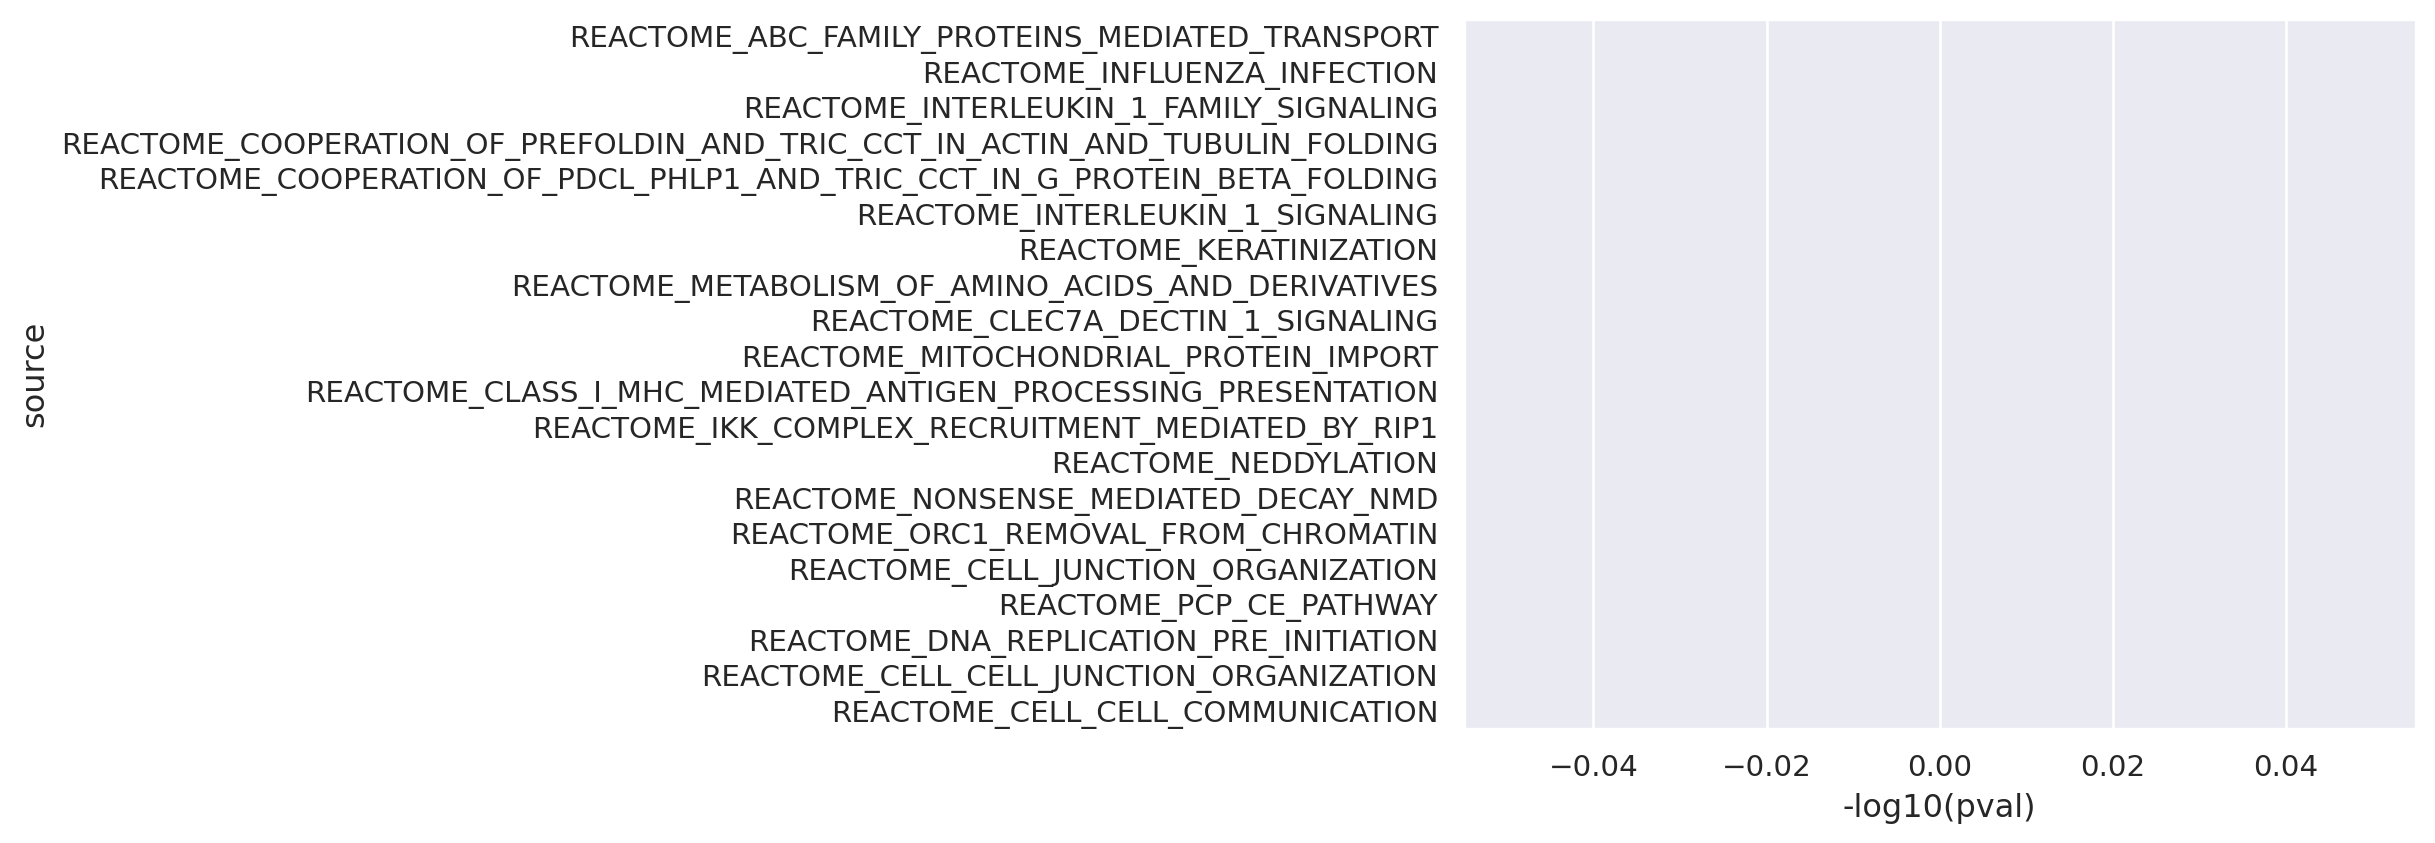

In [247]:
(
    so.Plot(
        data=(
            gsea_results.head(20).assign(
                **{"-log10(pval)": lambda x: -np.log10(x["pval"])}
            )
        ),
        x="-log10(pval)",
        y="source",
    ).add(so.Bar())
)

In [ ]:
# Cluster 1
get_t_statistics("1")

In [ ]:
# Cluster 1
get_t_statistics("2")

In [ ]:
# Cluster 1
get_t_statistics("3")

In the  graph, the y-axis represents the names of pathways, while the x-axis illustrates the adjusted p-values. The greater the height of the bar, the more pronounced the significance of the pathway. The pathways are arranged in order of their level of significance.

In [231]:
reactome=reactome["genesymbol"].to_list()

In [233]:
reactome.index("CTSL")

3446

# Results and Discussion
- Cathepsin L (CTSL), is a lysosomal acid cysteine protease that has been reported to play a critical role in chemosensitivity and tumor progression. I has been found that CTSL served as a prognostic marker for poor clinical outcomes in Neuroblastoma patients [4] and breat cancer [5].
-  AREG has ben suggested as a valuable prognostic biomarker in invasive breast cancer and promising therapeutic targets, especially in ER-negative breast cancer [6]
- The study suggests co-expresion patterns of KRT8 and KRT 18 genes 8, 5 and 9. Previous studies have shown the co-expression of these genes in cancer breat patients [7].
- The expression of the HLA-DQA1 significantly upregulated in breast cancer a sin line with the previous findings [8].
-  IGFBP7 was reported to play tumor suppressive role in breast cancer[9]

# Conclusion
- This project has shown the co-expression pattersn for KRT8 and KRT 18 genes genes
- Most cancer associated genes are CTSL,AREG  and DCN

# References
https://tcr.amegroups.org/article/view/76142/html

1. Kim H, Whitman AA, Wisniewska K, Kakati RT, Garcia-Recio S, Calhoun BC, Franco HL, Perou CM, Spanheimer PM. Tamoxifen Response at Single Cell Resolution in Estrogen Receptor-Positive Primary Human Breast Tumors. bioRxiv [Preprint]. 2023 Apr 19:2023.04.01.535159. doi: 10.1101/2023.04.01.535159. Update in: Clin Cancer Res. 2023 Sep 25;: PMID: 37066379; PMCID: PMC10103953.
2. Wei Z, Shen Y, Zhou C, Cao Y, Deng H, Shen Z. CD3D: a prognostic biomarker associated with immune infiltration and immunotherapeutic response in head and neck squamous cell carcinoma. Bioengineered. 2022 May;13(5):13784-13800. doi: 10.1080/21655979.2022.2084254. PMID: 35712757; PMCID: PMC9276048.
3. Lu, J., Ahmad, R., Nguyen, T. et al. Heterogeneity and transcriptome changes of human CD8+ T cells across nine decades of life. Nat Commun 13, 5128 (2022). https://doi.org/10.1038/s41467-022-32869-x
4. Du, X., Ding, L., Huang, S., Li, F., Yan, Y., Tang, R., ... & Wang, W. (2022). Cathepsin L promotes chemresistance to neuroblastoma by modulating serglycin. Frontiers in Pharmacology, 13, 920022.
5. Zhang, L., Zhao, Y., Yang, J., Zhu, Y., Li, T., Liu, X., ... & Fu, J. (2023). CTSL, a prognostic marker of breast cancer, that promotes proliferation, migration, and invasion in cells in triple-negative breast cancer. Frontiers in Oncology, 13, 1158087.
6. Xiang, G., Liu, F., Liu, J., Meng, Q., Li, N., & Niu, Y. (2019). Prognostic role of Amphiregulin and the correlation with androgen receptor in invasive breast cancer. Pathology-Research and Practice, 215(6), 152414.
7. Wilson, C. A., & Dering, J. (2004). Recent translational research: microarray expression profiling of breast cancer–beyond classification and prognostic markers?. Breast Cancer Research, 6, 1-9.
8. Wu, G., Xiao, G., Yan, Y., Guo, C., Hu, N., & Shen, S. (2022). Bioinformatics analysis of the clinical significance of HLA class II in breast cancer. Medicine, 101(40).
9. Li, D., Xia, L., Huang, P., Wang, Z., Guo, Q., Huang, C., ... & Qin, S. (2023). Cancer-associated fibroblast-secreted IGFBP7 promotes gastric cancer by enhancing tumor associated macrophage infiltration via FGF2/FGFR1/PI3K/AKT axis. Cell Death Discovery, 9(1), 17.
10. https://www.sc-best-practices.org/introduction/analysis_tools.html
11. https://www.sc-best-practices.org/conditions/gsea_pathway.html